In [1]:
## Loding libraries
import pystan
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import arviz as az
import pickle

In [2]:
## Preprocecing ##
jh_dir = "../../COVID-19"
Confirmed = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv")
df = Confirmed.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
confirmed = df
confirmed = confirmed.cummax()
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
recovered = df.cummax()
df = pd.read_csv(jh_dir + "/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv")
df = df.groupby("Country/Region").sum()
df = df.drop(["Lat", "Long"], 1)
df = df.T
df = df.set_index(pd.to_datetime(df.index))
death = df.cummax()

In [3]:
## Definitions ##

In [4]:
### dates ###
epoch = pd.to_datetime('2020-01-22')
last = pd.to_datetime('2020-05-06')
upto = last-pd.Timedelta(days=2)
index= pd.date_range(start=epoch, end=upto)

In [5]:
### Fitting a model ###
def fit_and_infer(sm=None, data=None, country=None, population=None, detection_rate=1,
                  b_beta_0=0.1, inits='random', iteration=2000, start=epoch, last=last):
    if data is None:
        C0 = confirmed.loc[start:last, country].values
        D0 = death.loc[start:last, country].values
        P = population
        data = {'T': C0.shape[0], 'T0': 0, 'P': P, 'C0': C0, 'D0':D0, 
                'q0':detection_rate, 'b_beta_0':b_beta_0}
    fit = sm.sampling(data=data, iter=iteration, init=inits)
    print(fit)
    return az.from_pystan(fit, log_likelihood='log_lik')

In [6]:
### Extract data ###
def extract_var(var_name=None, data=None, start=epoch):
    d = data.posterior[var_name].stack(sample=('chain', 'draw')).values
    return pd.DataFrame(d, index=pd.date_range(start, end=start+pd.Timedelta(days=len(d)-1)))

In [7]:
### Drawing ###
def draw(data, index=index, name=None, line=None, label_name=None, value_name='value'):
    df = pd.DataFrame()
    dfs = []
    for label, samples in data.items():
        samples['Date'] = samples.index
        melted=pd.melt(samples, id_vars=['Date'])
        if label_name is not None:
            melted[label_name]=label
        dfs.append(melted)
    df = pd.concat(dfs)
    df = df.rename(columns={'value':value_name})
    if label_name is not None:
        g=sns.relplot(kind="line", data=df, aspect=2, ci='sd', x='Date', y=value_name, hue=label_name)
    else:
        g=sns.relplot(kind="line", data=df, aspect=2, ci='sd', x='Date', y=value_name)
    ax = g.axes[0][0]
    if line is not None:
        ax.axhline(y = line, color='grey', linestyle='--', linewidth=2, alpha=.7)
    g.savefig("{}.pdf".format(name))
    plt.show()

In [8]:
## Compile models ##
sm_const = pystan.StanModel(file="const.stan")
sm_const_q = pystan.StanModel(file="everyday-const-q.stan")
sm_every = pystan.StanModel(file="everyday.stan")

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_af9c64d5eae9f5635306a489c55c8d64 NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_5cd8be6e46ccd02931578633bb84615c NOW.
INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_ee2085594df7feb36fc67a80a17cc305 NOW.


In [9]:
## Model Validation ##

In [10]:
#### Constant parameters ####
from scipy.stats import poisson
def simulate(b, q, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q)]
    R_obs = [0]
    D_obs = [0]
    for t in index:
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C + NI
        R = R + NR
        D = ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':0.1, 'q0':q}

data = simulate(0.07, 0.2, 100, 0.04, 0.001, 1200_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)


Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     131.51    0.67  24.92  87.93 113.99 129.44 147.41 186.68   1375    1.0
b_beta       4.4e-3  1.5e-4 1.6e-3 2.0e-3 3.3e-3 4.2e-3 5.3e-3 8.3e-3    108   1.04
b[1]           0.02  6.7e-4   0.02 1.8e-3 9.2e-3   0.02   0.03   0.06    542   1.01
b[2]           0.03  6.0e-4   0.01 5.8e-3   0.02   0.03   0.04   0.06    598   1.01
b[3]           0.03  5.9e-4   0.01 5.7e-3   0.02   0.03   0.04   0.06    619   1.01
b[4]           0.03  5.8e-4   0.01 6.7e-3   0.02   0.03   0.04   0.06    667   1.01
b[5]           0.04  5.2e-4   0.02 9.3e-3   0.03   0.04   0.05   0.07    869    1.0
b[6]           0.04  4.6e-4   0.01   0.02   0.03   0.04   0.05   0.07   1046    1.0
b[7]           0.05  4.4e-4   0.01   0.02   0.04   0.05

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      42.24    2.25   22.4  19.45  28.06   36.3  49.39   98.5     99   1.06
b_beta       3.7e-3  1.7e-4 1.6e-3 1.6e-3 2.4e-3 3.4e-3 4.5e-3 7.6e-3     90   1.05
b[1]           0.03  4.8e-3   0.02 1.4e-3 8.5e-3   0.02   0.05   0.08     27   1.11
b[2]           0.04  4.0e-3   0.02 5.7e-3   0.02   0.04   0.06   0.08     33    1.1
b[3]           0.04  3.9e-3   0.02 6.7e-3   0.02   0.04   0.06   0.08     34   1.09
b[4]           0.05  3.6e-3   0.02 9.0e-3   0.03   0.04   0.06   0.08     37   1.08
b[5]           0.05  2.9e-3   0.02   0.01   0.03   0.05   0.07   0.08     49   1.07
b[6]           0.05  2.8e-3   0.02   0.02   0.04   0.05   0.07   0.09     47   1.07
b[7]           0.06  2.4e-3   0.02   0.02   0.04   0.05

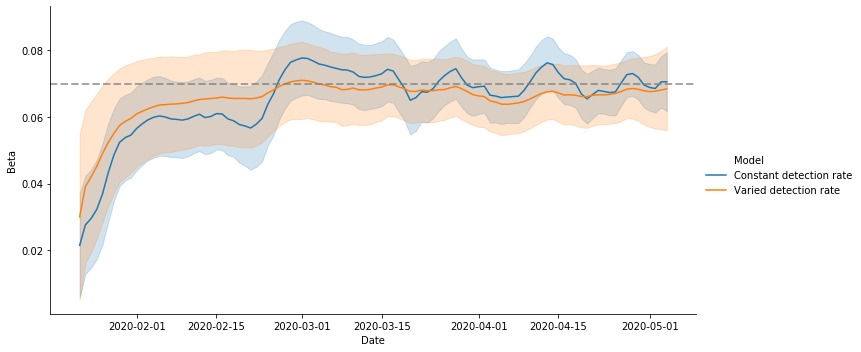

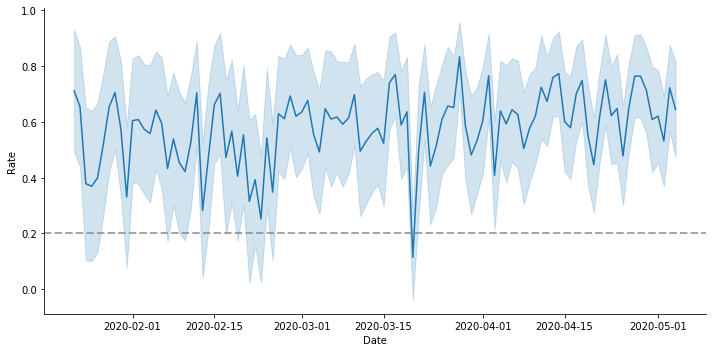

In [11]:
beta_const_q = extract_var(var_name='b', data=infered_const_q)
beta = extract_var(var_name='b', data=infered_every)
q = extract_var(var_name='q', data=infered_every)
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta}, name='const_beta', line=0.07, 
     label_name='Model', value_name='Beta')
draw({'Estimated':q}, line=0.2, name='const_q', label_name=None, value_name='Rate')

In [12]:
#### Step-like detection rate ####
from scipy.stats import poisson
def simulate(b, q1, q2, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q1)]
    D_obs = [0]
    R_obs = [0]
    q=[]
    for t in index:
        if t < pd.to_datetime('2020-04-01'):
            q.append(q1)
        else:
            q.append(q2)
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C+NI
        C_obs.append(int(C_obs[-1]+poisson.rvs(q[-1]*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 
            'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':0.1, 'q0':q1}, np.array(q)

data, q_true = simulate(0.07, 1, 0.5, 100, 0.04, 0.001, 1200_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)


Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     103.08    0.34  10.19  83.89  96.04 102.83 109.76 124.31    887   1.01
b_beta       3.5e-3  8.4e-5 1.1e-3 1.9e-3 2.7e-3 3.4e-3 4.1e-3 5.9e-3    157   1.02
b[1]           0.05  1.2e-3   0.02 3.7e-3   0.03   0.05   0.06   0.08    325    1.0
b[2]           0.06  5.3e-4   0.01   0.03   0.05   0.06   0.07   0.09    640    1.0
b[3]           0.06  4.7e-4   0.01   0.04   0.05   0.06   0.07   0.09    643    1.0
b[4]           0.07  4.2e-4   0.01   0.04   0.06   0.06   0.07   0.09    672   1.01
b[5]           0.07  4.1e-4   0.01   0.05   0.06   0.07   0.07   0.09    636   1.01
b[6]           0.07  4.2e-410.0e-3   0.05   0.06   0.07   0.07   0.09    568   1.01
b[7]           0.07  4.1e-4 9.7e-3   0.05   0.06   0.07

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     226.24   10.35 147.74 103.15 140.66 186.17 261.75 574.81    204   1.02
b_beta       3.1e-3  9.4e-5 1.1e-3 1.4e-3 2.3e-3 3.0e-3 3.7e-3 5.8e-3    137   1.02
b[1]           0.05  1.7e-3   0.03 3.8e-3   0.03   0.05   0.07   0.09    222   1.01
b[2]           0.06  1.3e-3   0.02   0.02   0.04   0.06   0.07   0.09    252   1.01
b[3]           0.06  1.2e-3   0.02   0.02   0.04   0.06   0.07   0.09    264   1.01
b[4]           0.06  1.2e-3   0.02   0.02   0.05   0.06   0.07    0.1    242   1.01
b[5]           0.06  1.2e-3   0.02   0.02   0.05   0.06   0.08    0.1    251   1.01
b[6]           0.06  1.2e-3   0.02   0.03   0.05   0.06   0.08    0.1    254   1.01
b[7]           0.06  1.1e-3   0.02   0.03   0.05   0.06

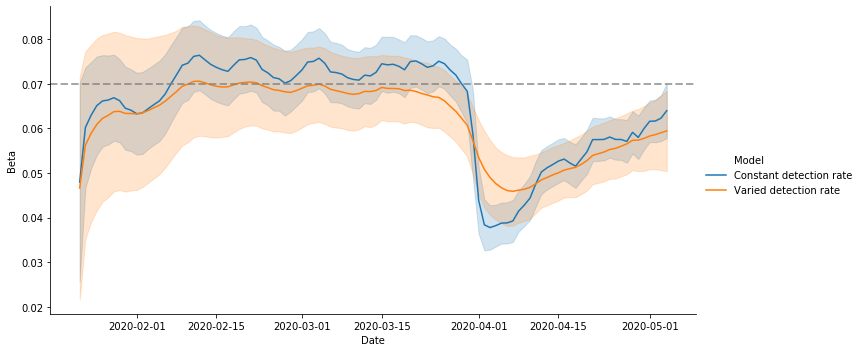

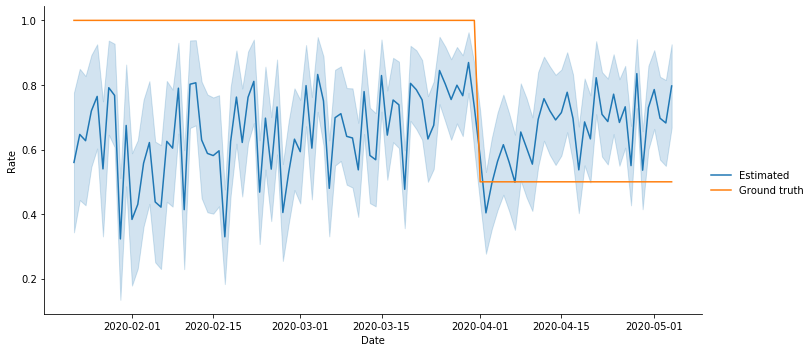

In [13]:
beta_const_q = extract_var(var_name='b', data=infered_const_q)
beta = extract_var(var_name='b', data=infered_every)
q = extract_var(var_name='q', data=infered_every)
                     
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta}, name='step_beta', 
     label_name='Model', value_name='Beta', line=0.07)

q_true = pd.DataFrame(q_true, index)
draw({'Estimated':q, 'Ground truth':q_true}, name='step_q', value_name='Rate', label_name='')

In [14]:
#### Changing beta ####
from scipy.stats import poisson
def simulate(b0, b1, q0, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q0)]
    q = [q0]
    D_obs = [0]
    R_obs = [0]
    b = [b0]
    for t in index:
        NI = poisson.rvs(b[-1]*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        C = C+NI
        I = I + NI - NR - ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q[-1]*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
        q.append(q0 + 0.05*np.random.randn(1)[0])
        b.append(b[-1] - b1)
 
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 
            'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':1, 'q0':q0}, np.array(q), np.array(b)
data, q_true, b_true = simulate(0.16, 0.001, 0.5, 100, 0.04, 0.001, 1200_0000, index)

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)


Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     104.56    0.33  14.26   79.0   94.5 104.05 113.77 134.97   1914    1.0
b_beta       8.2e-3  3.3e-5 1.3e-3 6.0e-3 7.3e-3 8.1e-3 9.0e-3   0.01   1450    1.0
b[1]           0.12  1.1e-3   0.04   0.03   0.09   0.12   0.14   0.18   1032   1.01
b[2]           0.12  9.0e-4   0.03   0.06   0.11   0.13   0.15   0.18   1109    1.0
b[3]           0.14  5.2e-4   0.02   0.09   0.12   0.14   0.15   0.18   1948    1.0
b[4]           0.14  4.8e-4   0.02    0.1   0.13   0.14   0.15   0.18   1878    1.0
b[5]           0.14  4.5e-4   0.02   0.11   0.13   0.14   0.16   0.18   1845    1.0
b[6]           0.15  4.2e-4   0.02   0.11   0.14   0.15   0.16   0.18   1870    1.0
b[7]           0.15  3.7e-4   0.02   0.12   0.14   0.15

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     100.32    1.62  41.03  52.33   71.9  91.44  118.7 200.22    642    1.0
b_beta       3.6e-3  7.0e-5 1.1e-3 1.9e-3 2.8e-3 3.5e-3 4.2e-3 6.2e-3    244   1.01
b[1]           0.13  1.3e-3   0.03   0.06   0.11   0.13   0.15   0.18    493   1.01
b[2]           0.13  1.1e-3   0.03   0.07   0.11   0.13   0.15   0.18    624   1.01
b[3]           0.13  9.2e-4   0.03   0.08   0.12   0.13   0.15   0.18    737    1.0
b[4]           0.13  8.8e-4   0.02   0.08   0.12   0.14   0.15   0.18    753    1.0
b[5]           0.14  8.6e-4   0.02   0.09   0.12   0.14   0.15   0.18    754    1.0
b[6]           0.14  8.1e-4   0.02   0.09   0.12   0.14   0.15   0.18    784    1.0
b[7]           0.14  7.6e-4   0.02   0.09   0.12   0.14

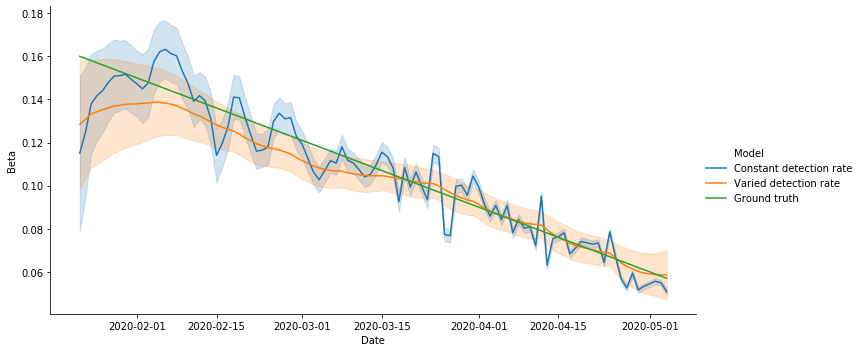

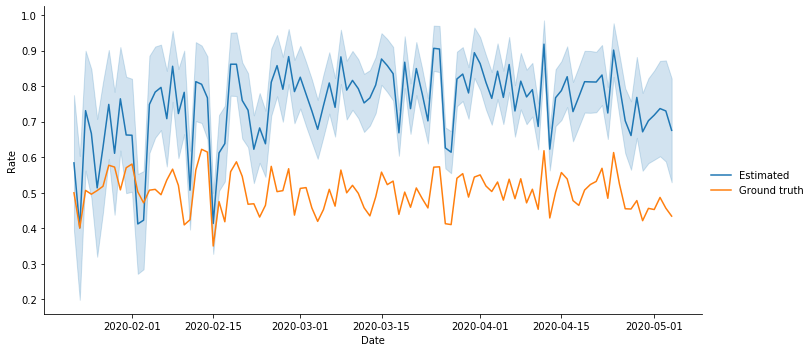

In [15]:
beta_const_q = extract_var(var_name='b', data=infered_const_q)
beta = extract_var('b', infered_every)
q = extract_var('q', infered_every)
b = extract_var('b', infered_every)
                  
b_true = pd.DataFrame(b_true[:-1], index)
draw({'Constant detection rate':beta_const_q, 'Varied detection rate':beta, 'Ground truth':b_true}, 
     name='trend_beta', label_name='Model', value_name='Beta')

q_true = pd.DataFrame(q_true[:-1], index)
draw({'Estimated':q, 'Ground truth':q_true}, name='trend_q', value_name='Rate', label_name='')

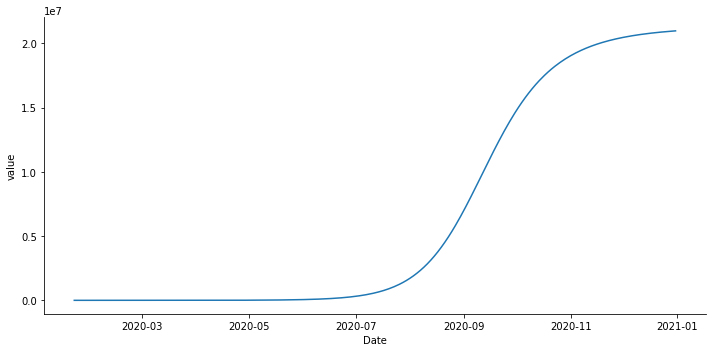

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      33.91   20.63  32.89   0.81   1.91  15.24  68.86  90.83      3   3.63
b_beta       1.0e-4  7.0e-6 2.5e-5 6.6e-5 8.4e-5 1.0e-4 1.2e-4 1.6e-4     13   1.47
b[1]           0.47    0.36   0.52    0.1    0.1    0.2   0.97   1.42      2  10.15
b[2]           0.47    0.36   0.52    0.1    0.1    0.2   0.97   1.42      2  10.15
b[3]           0.47    0.36   0.52    0.1    0.1    0.2   0.97   1.42      2  10.15
b[4]           0.47    0.36   0.52    0.1    0.1    0.2   0.97   1.42      2  10.15
b[5]           0.47    0.36   0.52    0.1    0.1    0.2   0.97   1.42      2  10.15
b[6]           0.47    0.36   0.52    0.1    0.1    0.2   0.97   1.42      2  10.16
b[7]           0.46    0.37   0.52    0.1    0.1    0.2

To run all diagnostics call pystan.check_hmc_diagnostics(fit)


Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      27.65    0.48   9.43  14.78  21.12  25.82  32.13  51.93    381   1.01
b_beta       9.6e-4  1.2e-5 1.6e-4 6.8e-4 8.5e-4 9.6e-4 1.1e-3 1.3e-3    165   1.02
b[1]            0.1  6.3e-4   0.01   0.08   0.09    0.1    0.1   0.12    307   1.01
b[2]            0.1  6.3e-4   0.01   0.08   0.09    0.1    0.1   0.12    302   1.01
b[3]            0.1  6.2e-4   0.01   0.08   0.09    0.1    0.1   0.12    305   1.01
b[4]            0.1  6.1e-4   0.01   0.08   0.09    0.1    0.1   0.12    302   1.01
b[5]            0.1  5.0e-4 9.8e-3   0.08   0.09    0.1    0.1   0.12    379   1.01
b[6]            0.1  5.0e-4 9.7e-3   0.08   0.09    0.1    0.1   0.12    379   1.01
b[7]            0.1  5.0e-4 9.5e-3   0.08   0.09    0.1

In [16]:
#### Saturate ####
from scipy.stats import poisson
def simulate(b, q, init_inf, a, d, P, index):
    C = init_inf
    I = init_inf
    R = 0
    D = 0
    C_obs = [poisson.rvs(init_inf*q)]
    R_obs = [0]
    D_obs = [0]
    for t in index:
        NI = poisson.rvs(b*I*(1-C/P))
        NR = poisson.rvs(a*I)
        ND = poisson.rvs(d*I)
        I = I + NI - NR - ND
        C = C + NI
        R = R + NR
        D = ND
        C_obs.append(int(C_obs[-1]+poisson.rvs(q*NI)))
        D_obs.append(int(D_obs[-1]+poisson.rvs(d*(C_obs[-1]-R_obs[-1]-D_obs[-1]))))
        R_obs.append(R_obs[-1]+a*(C_obs[-1]-R_obs[-1]-D_obs[-1]))
    return {'C0':np.array(C_obs), 'D0':np.array(D_obs), 'T':len(C_obs), 'T0':0, 'P':P, 'b_beta_0':0.1, 'q0':q}

index=pd.date_range(start=epoch, end=pd.to_datetime('2020-12-31'))
data = simulate(0.10, 0.2, 100, 0.04, 0.001, 12000_0000,index)
C0 = pd.DataFrame(data['C0'][:-1], index)
draw({'Cumulative':C0})

infered_const_q = fit_and_infer(sm=sm_const_q, data=data)
infered_every = fit_and_infer(sm=sm_every, data=data)

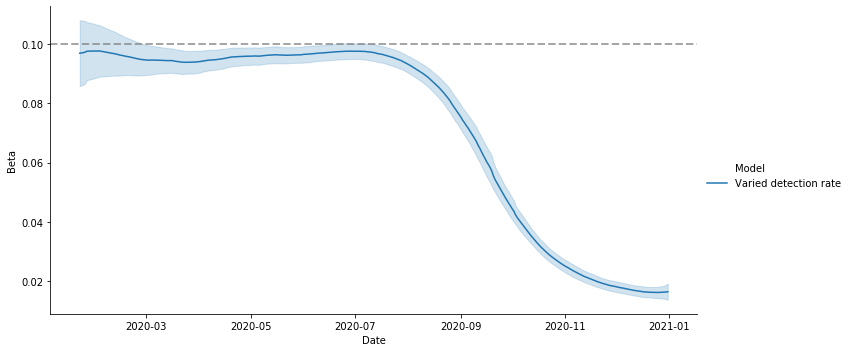

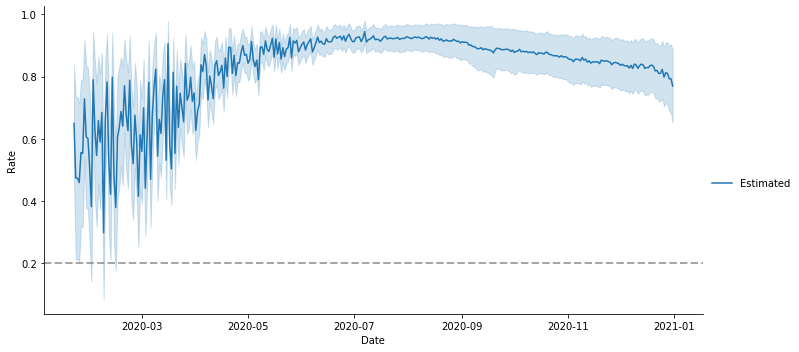

In [17]:
beta_const_q = extract_var('b', infered_const_q)
beta = extract_var('b', infered_every)
q = extract_var('q', infered_every)
draw({'Varied detection rate':beta}, name='saturate_beta', line=0.10, 
     label_name='Model', value_name='Beta')
draw({'Estimated':q}, line=0.2, name='saturate_q', value_name='Rate', label_name='')

In [18]:
## Analysis ##
iteration = 10000

In [19]:
### Japanese case ###
P = 126_500_000
infer_const = fit_and_infer(sm=sm_const, country='Japan', population=P, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country='Japan', population=P, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country='Japan', population=P, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
print(az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer}))

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      15.22    0.02   3.63   8.86  12.67  14.97  17.51  23.02  23034    1.0
b              0.08  5.6e-6 7.6e-4   0.08   0.08   0.08   0.08   0.09  18525    1.0
q               1.0  2.6e-6 4.6e-4    1.0    1.0    1.0    1.0    1.0  30689    1.0
NI[1]          1.42  5.9e-3   0.87    0.1   0.73   1.31   1.98   3.34  21607    1.0
NI[2]           1.5  6.3e-3   0.91    0.1   0.79    1.4   2.08    3.5  20773    1.0
NI[3]           1.6  6.5e-3   0.93   0.12   0.89   1.52   2.21   3.64  20302    1.0
NI[4]          2.64  6.1e-3   0.96   0.95   1.96   2.57   3.25   4.69  24639    1.0
NI[5]          1.79  7.6e-3   1.04   0.14   0.99    1.7   2.47   4.08  18898    1.0
NI[6]          3.27  6.4e-3   1.04   1.41   2.54   3.

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       1.63  6.1e-3   0.84   0.45   1.03   1.48   2.06   3.68  19092    1.0
b_beta         0.06  5.2e-5 7.1e-3   0.05   0.05   0.06   0.06   0.07  18792    1.0
b[1]           0.09  6.2e-4   0.08 4.0e-3   0.03   0.07   0.12   0.29  15127    1.0
b[2]           0.14  7.8e-4   0.09   0.01   0.07   0.12   0.19   0.36  13570    1.0
b[3]           0.19  8.4e-4    0.1   0.03   0.11   0.17   0.24   0.41  13566    1.0
b[4]           0.23  8.2e-4    0.1   0.07   0.16   0.22   0.29   0.45  14331    1.0
b[5]           0.24  8.6e-4    0.1   0.07   0.18   0.24    0.3   0.46  13207    1.0
b[6]           0.27  7.9e-4   0.09    0.1    0.2   0.26   0.32   0.47  14196    1.0
b[7]           0.26  8.2e-4   0.09   0.09    0.2   0.

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       5.82     0.1    5.6   1.13   2.62   4.16   6.88  20.81   3191    1.0
b_beta         0.01  1.1e-4 3.8e-3 7.8e-3   0.01   0.01   0.02   0.02   1269    1.0
b[1]           0.06  1.2e-3   0.06 1.6e-3   0.01   0.04    0.1   0.22   3037    1.0
b[2]            0.1  1.1e-3   0.07 7.0e-3   0.04   0.09   0.14   0.25   3698    1.0
b[3]           0.12  9.9e-4   0.06   0.02   0.07   0.12   0.16   0.26   4254    1.0
b[4]           0.14  8.5e-4   0.06   0.04    0.1   0.14   0.18   0.27   4636    1.0
b[5]           0.15  8.0e-4   0.06   0.05   0.11   0.15   0.18   0.27   4757    1.0
b[6]           0.16  7.6e-4   0.05   0.07   0.12   0.16   0.19   0.27   4607    1.0
b[7]           0.16  7.3e-4   0.05   0.07   0.13   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo  4370.98   730.64
p_loo   1103.18        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       29   27.6%
 (0.5, 0.7]   (ok)         27   25.7%
   (0.7, 1]   (bad)        12   11.4%
   (1, Inf)   (very bad)   37   35.2%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   759.43    28.91
p_loo     92.21        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       10    9.5%
 (0.5, 0.7]   (ok)         13   12.4%
   (0.7, 1]   (bad)        63   60.0%
   (1, Inf)   (very bad)   19   18.1%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densiti

Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   747.34    28.93
p_loo     88.67        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        5    4.8%
 (0.5, 0.7]   (ok)         10    9.5%
   (0.7, 1]   (bad)        80   76.2%
   (1, Inf)   (very bad)   10    9.5%

         rank     waic   p_waic   d_waic     weight       se      dse warning  \
Varied_q    0   677.79  53.8918        0   0.971577  974.874        0    True   
Const_q     1   687.75  56.3692  9.96056  0.0284231  27.5476  3.74088    True   
Const       2  5189.06  1512.23  4511.27          0   28.245  977.547    True   

         waic_scale  
Varied_q   deviance  
Const_q    deviance  
Const      deviance  


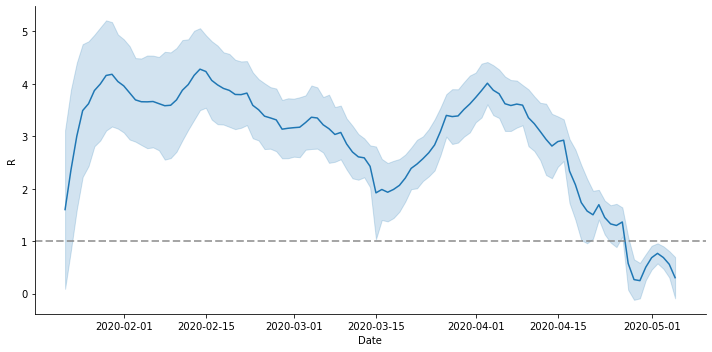

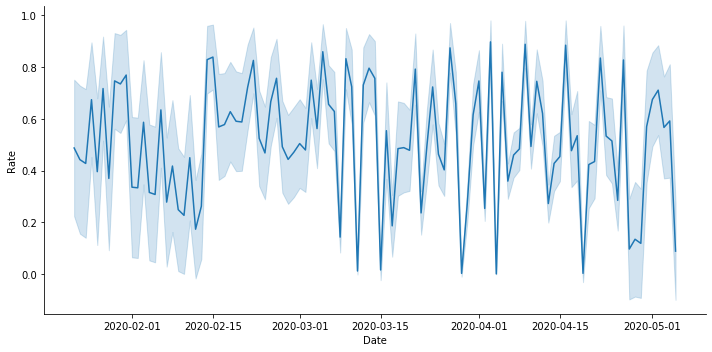

In [20]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
R_J = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_J}, line=1, name='R_Japan', value_name='R')
draw({'Detection rate':q}, name='q_Japan', value_name='Rate')

In [21]:
### China ###
P = 1_393_000_000
country='China'
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     6721.8    0.51  85.77 6554.2 6664.0 6721.4 6779.0 6892.6  27954    1.0
b              0.06  1.5e-6 2.6e-4   0.06   0.06   0.06   0.06   0.06  29377    1.0
q               1.0  2.3e-7 3.8e-5    1.0    1.0    1.0    1.0    1.0  28065    1.0
NI[1]        442.49    0.09  17.41 408.52 430.87 442.45 454.24 476.37  38072    1.0
NI[2]        564.43    0.09  16.73 531.61 552.98 564.36 575.88 597.14  33410    1.0
NI[3]        675.92    0.09  16.66 643.02 664.67 675.87 687.23 708.81  37164    1.0
NI[4]        767.38    0.09  16.57 734.89 756.25 767.45  778.5 799.63  36585    1.0
NI[5]        837.89    0.09   17.1 804.37 826.25 837.77 849.41 871.73  32630    1.0
NI[6]        1320.2    0.09  16.83 1287.4 1308.8 1320

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     556.56    0.17  23.14 512.33 540.59 556.27 572.04 602.98  19069    1.0
b_beta       6.6e-3  8.3e-6 1.2e-3 4.6e-3 5.8e-3 6.5e-3 7.3e-3 9.3e-3  20885    1.0
b[1]           0.17  1.8e-4   0.03   0.12   0.15   0.17   0.19   0.23  23247    1.0
b[2]           0.47  1.6e-4   0.02   0.44   0.46   0.47   0.49   0.52  15512    1.0
b[3]           0.48  1.6e-4   0.02   0.44   0.46   0.48   0.49   0.52  13317    1.0
b[4]           0.47  1.5e-4   0.02   0.44   0.46   0.47   0.49   0.51  14496    1.0
b[5]           0.46  1.7e-4   0.02   0.42   0.45   0.46   0.48    0.5  13206    1.0
b[6]           0.98  2.3e-4   0.03   0.91   0.96   0.98    1.0   1.04  21236    1.0
b[7]           0.11  4.5e-5 6.8e-3    0.1   0.11   0.

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     9811.1   27.77 1367.0 7509.4 8876.6 9684.0  1.1e4  1.3e4   2423    1.0
b_beta       1.1e-3  4.7e-6 2.4e-4 6.7e-4 9.0e-4 1.0e-3 1.2e-3 1.6e-3   2750    1.0
b[1]           0.16  1.9e-4 9.9e-3   0.14   0.16   0.16   0.17   0.18   2781    1.0
b[2]           0.16  1.9e-4 9.8e-3   0.14   0.16   0.16   0.17   0.18   2729    1.0
b[3]           0.16  1.9e-4 9.8e-3   0.14   0.16   0.16   0.17   0.18   2647    1.0
b[4]           0.16  1.9e-4 9.7e-3   0.14   0.16   0.16   0.17   0.18   2568    1.0
b[5]           0.16  1.9e-4 9.6e-3   0.14   0.16   0.16   0.17   0.18   2497    1.0
b[6]           0.16  1.9e-4 9.5e-3   0.14   0.16   0.16   0.17   0.18   2423    1.0
b[7]           0.16  1.9e-4 9.4e-3   0.14   0.16   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo 42127.01  18541.35
p_loo   3953.88        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          1    1.0%
   (0.7, 1]   (bad)         6    5.7%
   (1, Inf)   (very bad)   98   93.3%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   974.43    24.91
p_loo     99.28        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          3    2.9%
   (0.7, 1]   (bad)        87   82.9%
   (1, Inf)   (very bad)   15   14.3%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densiti

Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   945.99    23.11
p_loo     87.49        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        1    1.0%
 (0.5, 0.7]   (ok)          1    1.0%
   (0.7, 1]   (bad)        98   93.3%
   (1, Inf)   (very bad)    5    4.8%



,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,872.687,50.8369,0,0.998532,31067.9,0,True,deviance
Const_q,1,890.356,57.2444,17.6685,0.00146758,22.573,5.49196,True,deviance
Const,2,58624.6,12202.7,57751.9,0,21.3941,27519.1,True,deviance


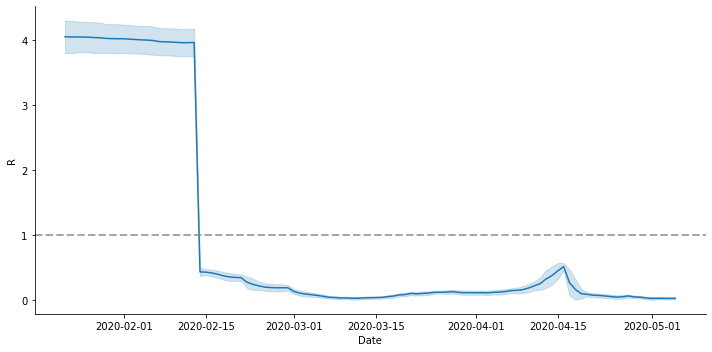

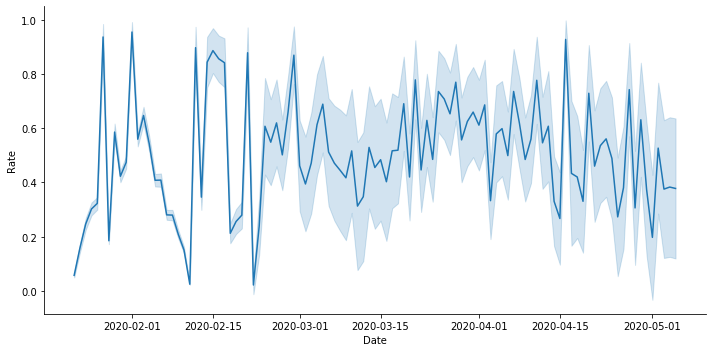

In [22]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
R_C = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_C}, line=1, name='R_China', value_name='R')
draw({'Detection rate':q}, name='q_China', value_name='Rate')

In [23]:
### US ###
P = 327_200_000
country='US'
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     285.14    0.11  17.85 251.39 272.73 284.89 297.14 320.95  27648    1.0
b              0.09  6.0e-7 8.7e-5   0.09   0.09   0.09   0.09   0.09  21066    1.0
q               1.0  9.9e-8 1.5e-5    1.0    1.0    1.0    1.0    1.0  24355    1.0
NI[1]         25.32    0.03   4.81  15.89  22.11  25.34  28.57  34.72  23951    1.0
NI[2]         28.41    0.03   4.83  19.11  25.08  28.37  31.78  37.68  27386    1.0
NI[3]         29.95    0.03   5.01  20.15  26.56  29.92  33.35  39.78  23413    1.0
NI[4]         34.74    0.03   5.05  24.85  31.36   34.7  38.11   44.7  27352    1.0
NI[5]         35.31    0.03   5.34   25.0  31.66  35.32  38.91   45.7  24607    1.0
NI[6]          38.4    0.03   5.52  27.68  34.66  38.

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       1.45  6.5e-3   0.81   0.34   0.88    1.3   1.86   3.43  15365    1.0
b_beta         0.03  5.2e-5 5.1e-3   0.02   0.03   0.03   0.03   0.04   9512    1.0
b[1]           0.06  4.7e-4   0.05 2.7e-3   0.02   0.04   0.08   0.19  11794    1.0
b[2]            0.1  5.3e-4   0.06   0.02   0.05   0.09   0.13   0.23  11108    1.0
b[3]           0.11  5.9e-4   0.06   0.02   0.07   0.11   0.15   0.25   9811    1.0
b[4]           0.13  5.8e-4   0.06   0.04   0.09   0.12   0.16   0.26   9377    1.0
b[5]           0.13  6.8e-4   0.06   0.03   0.08   0.12   0.16   0.26   7390    1.0
b[6]           0.12  7.2e-4   0.06   0.03   0.08   0.12   0.16   0.26   6711    1.0
b[7]           0.13  7.2e-4   0.06   0.02   0.08   0.

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       3.06    0.03   2.57   0.64   1.56   2.38   3.74   9.52   6369    1.0
b_beta         0.02  8.8e-5 3.7e-3 9.9e-3   0.01   0.02   0.02   0.02   1766    1.0
b[1]           0.05  5.8e-4   0.05 2.2e-3   0.02   0.04   0.07   0.18   7186    1.0
b[2]           0.08  6.0e-4   0.05   0.01   0.05   0.07   0.11    0.2   6888    1.0
b[3]            0.1  6.1e-4   0.05   0.02   0.06   0.09   0.13   0.21   6603    1.0
b[4]           0.11  5.8e-4   0.05   0.04   0.08    0.1   0.14   0.22   6528    1.0
b[5]           0.11  5.9e-4   0.05   0.04   0.08   0.11   0.14   0.22   6316    1.0
b[6]           0.11  6.1e-4   0.05   0.04   0.08   0.11   0.14   0.22   5865    1.0
b[7]           0.12  5.9e-4   0.05   0.04   0.08   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo 128513.82  12719.13
p_loo  12654.54        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        0    0.0%
 (0.5, 0.7]   (ok)          2    1.9%
   (0.7, 1]   (bad)         4    3.8%
   (1, Inf)   (very bad)   99   94.3%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo  1059.41    66.61
p_loo    110.86        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       20   19.0%
 (0.5, 0.7]   (ok)         15   14.3%
   (0.7, 1]   (bad)        54   51.4%
   (1, Inf)   (very bad)   16   15.2%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo  1008.96    59.58
p_loo     90.89        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       18   17.1%
 (0.5, 0.7]   (ok)          8    7.6%
   (0.7, 1]   (bad)        69   65.7%
   (1, Inf)   (very bad)   10    9.5%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,940.407,56.6145,0,0.999994,21602.8,0,True,deviance
Const_q,1,983.013,72.6647,42.6066,6.36442e-06,65.1603,15.2528,True,deviance
Const,2,195396,46095.7,194456,0,60,21078.5,True,deviance


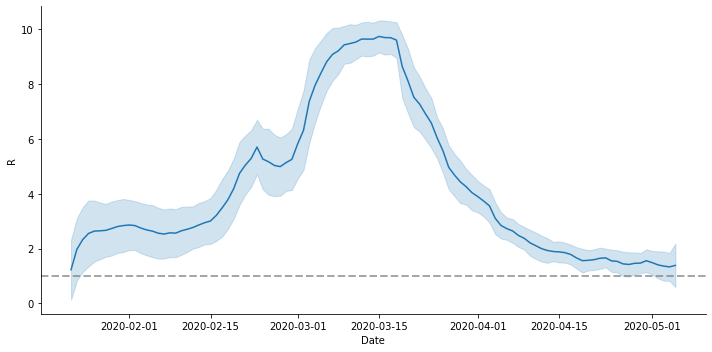

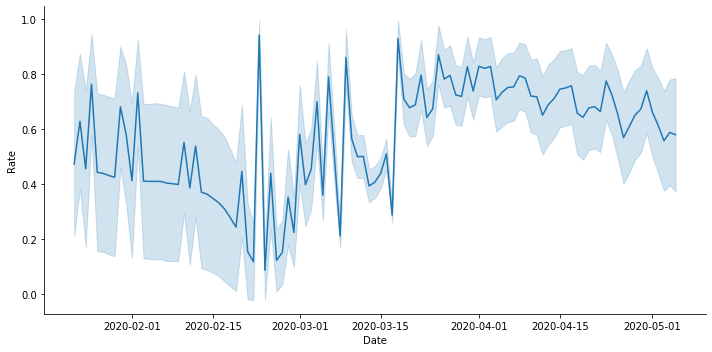

In [24]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer)
C = extract_var(var_name='C', data=infer)
C = C[:-1]
R_US = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_US}, line=1, name='R_US', value_name='R')
draw({'Detection rate':q}, name='q_US', value_name='Rate')

In [25]:
### Italy ###
P = 60_360_000
country='Italy'
start=pd.to_datetime('2020-02-01')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf    1008.3    0.25  34.88 941.08  984.4 1007.9 1032.2 1077.3  20041    1.0
b             0.07  1.1e-6 1.6e-4   0.07   0.07   0.07   0.07   0.07  20573    1.0
q              1.0  3.1e-7 4.8e-5    1.0    1.0    1.0    1.0    1.0  23913    1.0
NI[1]        71.53    0.06   8.11  55.56  66.06  71.52  76.98   87.4  20792    1.0
NI[2]        76.37    0.06   8.24  60.11  70.85  76.38  81.86  92.36  20525    1.0
NI[3]        81.68    0.06   8.35  65.31  76.14  81.67  87.26  98.07  21465    1.0
NI[4]        87.36    0.06   8.52   70.7  81.63  87.31  93.05 104.26  21266    1.0
NI[5]        93.29    0.06   8.56  76.68  87.49  93.28  99.07 110.07  21608    1.0
NI[6]        100.5    0.06   8.85  83.27  94.46 100.47  106.4 

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      1.76    0.02   0.98   0.44   1.07   1.57   2.24   4.18   2847    1.0
b_beta        0.02  3.1e-5 2.8e-3   0.01   0.01   0.02   0.02   0.02   7930    1.0
b[1]          0.02  2.1e-4   0.02 1.0e-3 8.9e-3   0.02   0.03   0.09  12260    1.0
b[2]          0.04  2.9e-4   0.03 2.9e-3   0.02   0.03   0.05   0.11   9555    1.0
b[3]          0.05  3.6e-4   0.03 5.4e-3   0.03   0.04   0.06   0.12   7542    1.0
b[4]          0.06  4.4e-4   0.03 7.9e-3   0.03   0.05   0.08   0.13   5536    1.0
b[5]          0.07  5.3e-4   0.03   0.01   0.04   0.06   0.08   0.15   4263    1.0
b[6]          0.07  5.8e-4   0.04   0.02   0.05   0.07   0.09   0.15   3709    1.0
b[7]          0.07  6.8e-4   0.04   0.02   0.05   0.07    0.1 

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      2.33    0.04   2.25   0.44   1.14   1.79   2.77   7.47   2939    1.0
b_beta        0.01  7.6e-5 2.9e-3 5.9e-3 8.7e-3   0.01   0.01   0.02   1481    1.0
b[1]          0.04  2.0e-3   0.07 7.9e-4 6.7e-3   0.01   0.03   0.28   1093    1.0
b[2]          0.06  2.7e-3   0.08 2.4e-3   0.02   0.03   0.07   0.33    929    1.0
b[3]          0.09  3.5e-3    0.1 4.6e-3   0.02   0.05    0.1   0.36    784   1.01
b[4]          0.11  3.8e-3   0.11 7.7e-3   0.03   0.07   0.15   0.38    829   1.01
b[5]          0.13  4.2e-3   0.12   0.01   0.05   0.09    0.2    0.4    765    1.0
b[6]          0.16  4.5e-3   0.12   0.02   0.06   0.11   0.26   0.42    742    1.0
b[7]          0.17  4.9e-3   0.13   0.02   0.07   0.13   0.28 

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 95 log-likelihood matrix

       Estimate       SE
IC_loo 40237.85  4261.53
p_loo   6311.19        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        1    1.1%
 (0.5, 0.7]   (ok)          1    1.1%
   (0.7, 1]   (bad)         6    6.3%
   (1, Inf)   (very bad)   87   91.6%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 95 log-likelihood matrix

       Estimate       SE
IC_loo   937.79    45.99
p_loo     82.10        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       21   22.1%
 (0.5, 0.7]   (ok)          4    4.2%
   (0.7, 1]   (bad)        54   56.8%
   (1, Inf)   (very bad)   16   16.8%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 95 log-likelihood matrix

       Estimate       SE
IC_loo   929.64    40.59
p_loo     79.07        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       10   10.5%
 (0.5, 0.7]   (ok)          4    4.2%
   (0.7, 1]   (bad)        75   78.9%
   (1, Inf)   (very bad)    6    6.3%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,865.917,47.2049,0,0.673012,6377.21,0,True,deviance
Const_q,1,872.12,49.2686,6.20296,0.326988,43.5599,12.6432,True,deviance
Const,2,55367.7,13876.1,54501.8,0,40.5603,6453.54,True,deviance


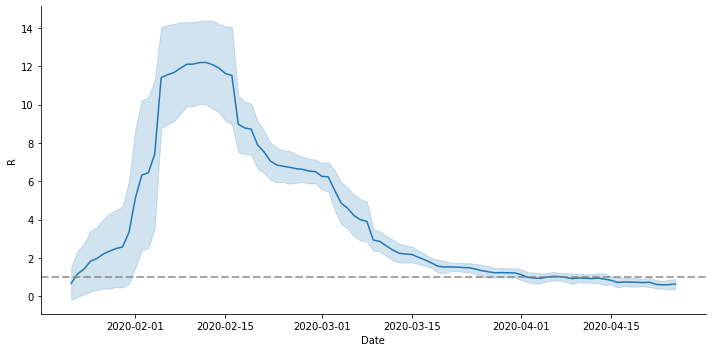

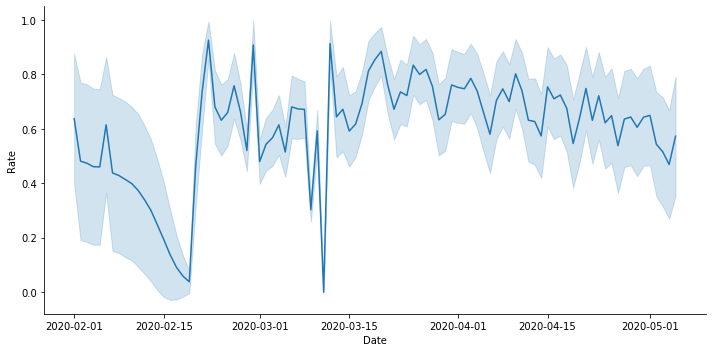

In [26]:
beta = extract_var(var_name='b', data=infer)
q = extract_var(var_name='q', data=infer, start=start)
C = extract_var(var_name='C', data=infer, start=start)
C = C[:-1]
R_I = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_I}, line=1, name='R_Italy', value_name='R')
draw({'Detection rate':q}, name='q_Italy', value_name='Rate')

In [27]:
### Korea ###
P = 51_640_000
country='Korea, South'
start=pd.to_datetime('2020-01-22')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     147.87    0.07  13.87 121.42 138.35 147.64 156.92 176.11  36293    1.0
b              0.06  4.0e-6 7.0e-4   0.06   0.06   0.06   0.06   0.06  31331    1.0
q               1.0  2.0e-6 3.6e-4    1.0    1.0    1.0    1.0    1.0  30779    1.0
NI[1]          9.49    0.02   2.95   3.73   7.48   9.47  11.49  15.35  21724    1.0
NI[2]         10.96    0.02   2.87    5.5   8.99   10.9  12.91  16.71  31834    1.0
NI[3]         10.73    0.02   3.04   4.76   8.67  10.75  12.76  16.73  22043    1.0
NI[4]         12.19    0.02   2.96   6.43  10.17  12.16   14.2  18.13  32116    1.0
NI[5]         12.88    0.02   3.07   6.91  10.79  12.88  14.93  18.99  30238    1.0
NI[6]         12.85    0.02   3.19   6.63  10.69  12.

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf       2.48    0.02   1.38   0.65    1.5    2.2   3.16   5.94   7643    1.0
b_beta       8.8e-3  2.5e-5 1.7e-3 6.0e-3 7.7e-3 8.7e-3 9.9e-3   0.01   4406    1.0
b[1]           0.06  1.2e-3   0.06 1.3e-3   0.01   0.04    0.1   0.18   2156    1.0
b[2]           0.09  9.7e-4   0.05   0.01   0.05   0.09   0.12    0.2   2779    1.0
b[3]            0.1  8.5e-4   0.05   0.02   0.07    0.1   0.13    0.2   3136    1.0
b[4]           0.11  7.3e-4   0.04   0.04   0.08   0.11   0.14    0.2   3473    1.0
b[5]           0.12  6.5e-4   0.04   0.05   0.09   0.11   0.14    0.2   3767    1.0
b[6]           0.12  6.2e-4   0.04   0.05   0.09   0.12   0.14    0.2   3777    1.0
b[7]           0.12  5.8e-4   0.04   0.06    0.1   0.

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     145.72  149.67 407.34   0.35   0.91   1.41   2.45 1453.2      7   2.97
b_beta       2.9e-3  1.5e-4 1.1e-3 1.3e-3 2.2e-3 2.7e-3 3.5e-3 5.3e-3     53   1.12
b[1]           0.17    0.03   0.12 3.5e-4 4.3e-3   0.24   0.27   0.31     13   1.57
b[2]           0.22    0.04    0.1 1.2e-3   0.22   0.25   0.27   0.31      7   1.94
b[3]           0.22    0.04    0.1 1.1e-3   0.22   0.25   0.27   0.31      7   2.01
b[4]           0.22    0.03   0.09 1.5e-3   0.23   0.25   0.27   0.31      8   2.14
b[5]           0.22    0.03   0.09 1.7e-3   0.23   0.25   0.27   0.31      7   2.34
b[6]           0.22    0.03   0.09 1.5e-3   0.23   0.26   0.27   0.31      7   2.38
b[7]           0.22    0.03   0.09 1.8e-3   0.23   0.

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo  7125.50  1242.22
p_loo   1392.02        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        4    3.8%
 (0.5, 0.7]   (ok)          8    7.6%
   (0.7, 1]   (bad)        24   22.9%
   (1, Inf)   (very bad)   69   65.7%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   773.48    41.57
p_loo     95.12        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       18   17.1%
 (0.5, 0.7]   (ok)         14   13.3%
   (0.7, 1]   (bad)        64   61.0%
   (1, Inf)   (very bad)    9    8.6%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is g

Computed from 20000 by 105 log-likelihood matrix

       Estimate       SE
IC_loo   731.62    26.78
p_loo     83.02        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        5    4.8%
 (0.5, 0.7]   (ok)          8    7.6%
   (0.7, 1]   (bad)        87   82.9%
   (1, Inf)   (very bad)    5    4.8%



,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,667.261,50.8437,0,0.999845,1474.83,0,True,deviance
Const_q,1,715.389,66.0793,48.1279,0.000155246,38.013,25.8597,True,deviance
Const,2,7837,1747.77,7169.74,0,25.1077,1515.28,True,deviance


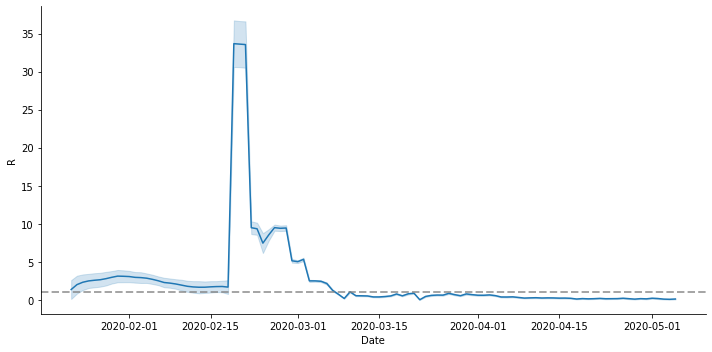

In [28]:
beta = extract_var(var_name='b', data=infer_const_q)
C = extract_var(var_name='C', data=infer_const_q)
C = C[:-1]
#d = extract_var(var_name='d', data=infer_const_q)
#print('{}, {}, {}'.format(beta.values.shape, d.values.shape, C.values.shape))
R_K = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_K}, line=1, name='R_Korea', value_name='R')

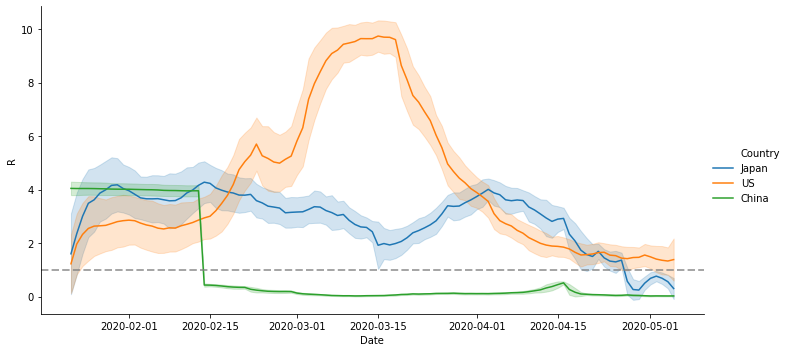

In [29]:
draw({'Japan':R_J, 'US':R_US, 'China':R_C}, line=1, name='R_multi', value_name='R', label_name='Country')

In [30]:
### Sweden ###
P = 10_230_000
country='Sweden'
start=pd.to_datetime('2020-02-01')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf     27.03    0.03   5.35  17.28  23.28  26.74  30.48  38.32  31368    1.0
b             0.08  3.9e-6 5.9e-4   0.08   0.08   0.08   0.08   0.08  22913    1.0
q              1.0  5.8e-6 1.0e-3    1.0    1.0    1.0    1.0    1.0  31247    1.0
NI[1]         2.38  9.5e-3   1.28   0.22   1.42   2.27   3.22   5.13  18308    1.0
NI[2]         2.54  9.4e-3   1.32    0.3   1.56   2.47   3.41   5.32  19571    1.0
NI[3]         2.71  9.9e-3   1.38   0.34   1.71   2.63   3.61   5.63  19199    1.0
NI[4]         2.91    0.01   1.43   0.37   1.87   2.84   3.86    5.9  18459    1.0
NI[5]         3.12    0.01   1.48   0.47   2.06   3.07    4.1   6.18  18529    1.0
NI[6]         3.37    0.01   1.54   0.57   2.27   3.31   4.39 

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      0.66  3.8e-3   0.48   0.07   0.31   0.55   0.89   1.86  15817    1.0
b_beta        0.02  4.6e-5 3.9e-3   0.02   0.02   0.02   0.03   0.03   7401    1.0
b[1]          0.03  2.2e-4   0.03 1.2e-3   0.01   0.02   0.04    0.1  14752    1.0
b[2]          0.04  2.9e-4   0.03 2.8e-3   0.02   0.04   0.06   0.13  12145    1.0
b[3]          0.05  3.6e-4   0.04 4.1e-3   0.03   0.05   0.07   0.14   9787    1.0
b[4]          0.06  4.3e-4   0.04 5.5e-3   0.03   0.05   0.08   0.15   8098    1.0
b[5]          0.07  4.8e-4   0.04 6.3e-3   0.04   0.06   0.09   0.16   7470    1.0
b[6]          0.07  5.1e-4   0.04 7.2e-3   0.04   0.06   0.09   0.17   6972    1.0
b[7]          0.07  5.4e-4   0.04 7.9e-3   0.04   0.07    0.1 

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      1.24  9.2e-3   0.94   0.17   0.62   1.03   1.61   3.62  10261    1.0
b_beta        0.01  7.6e-5 3.3e-3 7.4e-3   0.01   0.01   0.02   0.02   1938    1.0
b[1]          0.02  3.0e-4   0.02 9.2e-4 7.4e-3   0.02   0.03   0.09   6465    1.0
b[2]          0.04  4.5e-4   0.03 2.5e-3   0.02   0.03   0.05   0.11   4339    1.0
b[3]          0.05  5.1e-4   0.03 4.6e-3   0.02   0.04   0.06   0.13   4233    1.0
b[4]          0.05  5.6e-4   0.04 7.0e-3   0.03   0.05   0.07   0.14   3990    1.0
b[5]          0.06  6.2e-4   0.04 9.4e-3   0.04   0.06   0.08   0.16   3788    1.0
b[6]          0.07  6.8e-4   0.04   0.01   0.04   0.06   0.09   0.17   3509    1.0
b[7]          0.08  7.2e-4   0.04   0.01   0.05   0.07    0.1 

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 95 log-likelihood matrix

       Estimate       SE
IC_loo  3107.39   330.29
p_loo    710.13        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        8    8.4%
 (0.5, 0.7]   (ok)         25   26.3%
   (0.7, 1]   (bad)        28   29.5%
   (1, Inf)   (very bad)   34   35.8%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 95 log-likelihood matrix

       Estimate       SE
IC_loo   761.07    49.94
p_loo     91.89        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       27   28.4%
 (0.5, 0.7]   (ok)          7    7.4%
   (0.7, 1]   (bad)        48   50.5%
   (1, Inf)   (very bad)   13   13.7%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is g

Computed from 20000 by 95 log-likelihood matrix

       Estimate       SE
IC_loo   687.62    39.91
p_loo     66.25        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)       21   22.1%
 (0.5, 0.7]   (ok)          4    4.2%
   (0.7, 1]   (bad)        63   66.3%
   (1, Inf)   (very bad)    7    7.4%



,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,634.313,39.5946,0,1,367.169,0,True,deviance
Const_q,1,704.699,63.7068,70.3854,1.19142e-08,47.8428,25.7201,True,deviance
Const,2,3198.64,755.759,2564.33,0,37.444,374.089,True,deviance


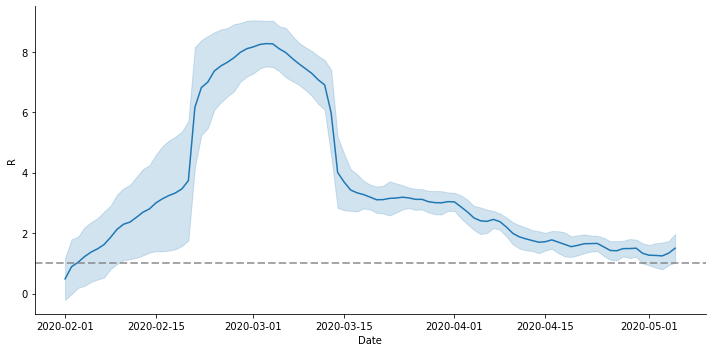

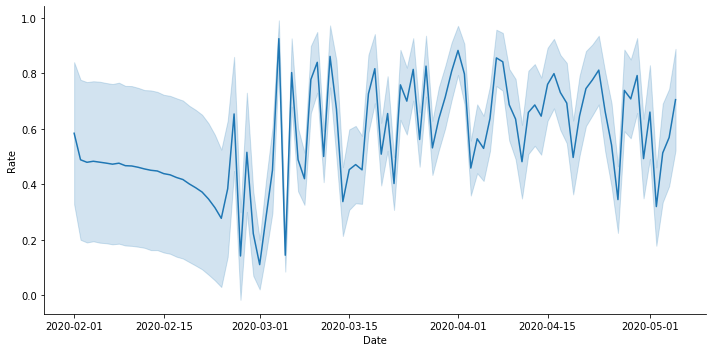

In [31]:
beta = extract_var(var_name='b', data=infer, start=start)
q = extract_var(var_name='q', data=infer, start=start)
C = extract_var(var_name='C', data=infer, start=start)
C = C[:-1]
R_S = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_S}, line=1, name='R_Sweden', value_name='R')
draw({'Detection rate':q}, name='q_Sweden', value_name='Rate')

In [32]:
### Denmark ###
P = 5_806_000
country='Denmark'
start=pd.to_datetime('2020-03-01')
infer_const = fit_and_infer(sm=sm_const, country=country, population=P, start=start, iteration=iteration)
infer_const_q = fit_and_infer(sm=sm_const_q, country=country, population=P, start=start, iteration=iteration)
infer = fit_and_infer(sm=sm_every, country=country, population=P, start=start, iteration=iteration)
loo = az.loo(infer_const, pointwise=True)
print(loo)
loo = az.loo(infer_const_q, pointwise=True)
print(loo)
loo = az.loo(infer, pointwise=True)
print(loo)
az.compare({'Const':infer_const, 'Const_q':infer_const_q, 'Varied_q':infer})

Inference for Stan model: anon_model_af9c64d5eae9f5635306a489c55c8d64.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf    262.04    0.12  16.49 230.55 250.68  261.8 272.95 294.96  17796    1.0
b             0.07  6.1e-6 8.3e-4   0.07   0.07   0.07   0.07   0.07  18141    1.0
q              1.0  1.0e-5 1.5e-3   0.99    1.0    1.0    1.0    1.0  22963    1.0
NI[1]         19.1    0.03   4.18  10.92  16.26  19.11  21.93  27.31  20133    1.0
NI[2]        22.08    0.03   4.07  14.22   19.3  22.04  24.83  30.08  19188    1.0
NI[3]        25.57    0.03   4.07  17.76  22.82  25.53  28.32  33.61  20699    1.0
NI[4]        23.45    0.03   4.42  14.87  20.44  23.43  26.47  32.17  20710    1.0
NI[5]        33.11    0.03   4.01  25.43  30.35  33.05  35.83  41.12  22586    1.0
NI[6]        26.83    0.03    4.6  17.88  23.68  26.82  29.93 

Inference for Stan model: anon_model_5cd8be6e46ccd02931578633bb84615c.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      3.11    0.07   1.75   0.86   1.82    2.7   4.01   7.45    650   1.01
b_beta        0.01  1.6e-4 3.2e-3 9.4e-3   0.01   0.01   0.02   0.02    414   1.02
b[1]          0.27    0.02   0.31 1.3e-3   0.01   0.11   0.44   0.99    160   1.04
b[2]          0.56    0.02   0.33   0.04   0.32   0.47   0.85   1.27    243   1.03
b[3]           0.6    0.02   0.32   0.16   0.35   0.49   0.88   1.31    217   1.04
b[4]           0.6    0.02   0.32   0.17   0.35    0.5   0.88   1.31    216   1.04
b[5]          0.62    0.02   0.32   0.19   0.37   0.51    0.9   1.35    267   1.03
b[6]          0.62    0.02   0.33   0.19   0.37   0.51   0.91   1.36    267   1.03
b[7]          0.98    0.04   0.46   0.31   0.54   0.96   1.37 

Inference for Stan model: anon_model_ee2085594df7feb36fc67a80a17cc305.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
init_inf      4.61    0.15   3.24    1.3   2.67   3.82   5.54  12.83    497   1.01
b_beta      8.8e-3  9.5e-5 2.7e-3 4.7e-3 6.9e-3 8.4e-3   0.01   0.02    841   1.01
b[1]          0.53    0.07   0.31 1.2e-3   0.38   0.67   0.75   0.88     21   1.15
b[2]          0.71  5.1e-3    0.1   0.52   0.65   0.71   0.78    0.9    378   1.02
b[3]          0.71  5.0e-3    0.1   0.52   0.65   0.71   0.78    0.9    372   1.02
b[4]          0.71  4.9e-3    0.1   0.53   0.65   0.71   0.78    0.9    374   1.02
b[5]          0.72  4.9e-3   0.09   0.53   0.65   0.71   0.78    0.9    377   1.02
b[6]          0.72  4.9e-3   0.09   0.53   0.66   0.71   0.78    0.9    372   1.02
b[7]          0.72  4.9e-3   0.09   0.53   0.66   0.71   0.78 

/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/numpy/core/_methods.py:38: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial, where)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is g

Computed from 20000 by 66 log-likelihood matrix

       Estimate       SE
IC_loo  2239.02   240.17
p_loo    491.55        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        4    6.1%
 (0.5, 0.7]   (ok)         11   16.7%
   (0.7, 1]   (bad)        19   28.8%
   (1, Inf)   (very bad)   32   48.5%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "


Computed from 20000 by 66 log-likelihood matrix

       Estimate       SE
IC_loo   633.73    28.80
p_loo     79.47        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        1    1.5%
 (0.5, 0.7]   (ok)          9   13.6%
   (0.7, 1]   (bad)        47   71.2%
   (1, Inf)   (very bad)    9   13.6%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:727: RuntimeWarning: overflow encountered in exp
  weights = 1 / np.exp(len_scale - len_scale[:, None]).sum(axis=1)


Computed from 20000 by 66 log-likelihood matrix

       Estimate       SE
IC_loo   582.03    13.31
p_loo     57.25        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)        1    1.5%
 (0.5, 0.7]   (ok)          1    1.5%
   (0.7, 1]   (bad)        59   89.4%
   (1, Inf)   (very bad)    5    7.6%



/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:527: UserWarning: Estimated shape parameter of Pareto distribution is greater than 0.7 for one or more samples. You should consider using a more robust model, this is because importance sampling is less likely to work well if the marginal posterior and LOO posterior are very different. This is more likely to happen with a non-robust model and highly influential observations.
  "Estimated shape parameter of Pareto distribution is greater than 0.7 for "
/Users/yoriyuki/.pyenv/versions/anaconda3-5.3.1/envs/COVID-19/lib/python3.7/site-packages/arviz/stats/stats.py:1196: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  "For one or more samples the posterior variance of the log predictive "


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Varied_q,0,534.288,33.3816,0,0.999787,242.098,0,True,deviance
Const_q,1,590.534,57.8717,56.2454,0.000213203,27.7749,28.0938,True,deviance
Const,2,2234.39,489.236,1700.1,2.20078e-239,11.6394,251.011,True,deviance


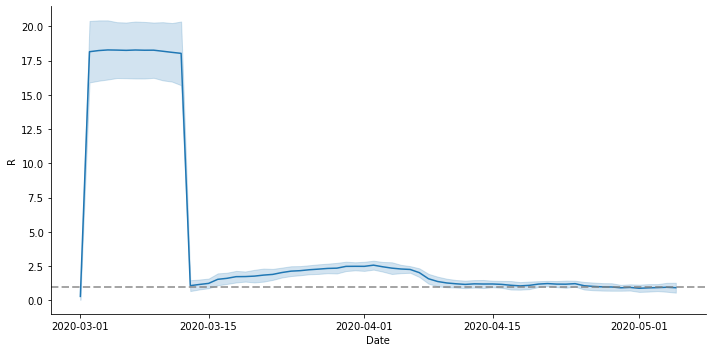

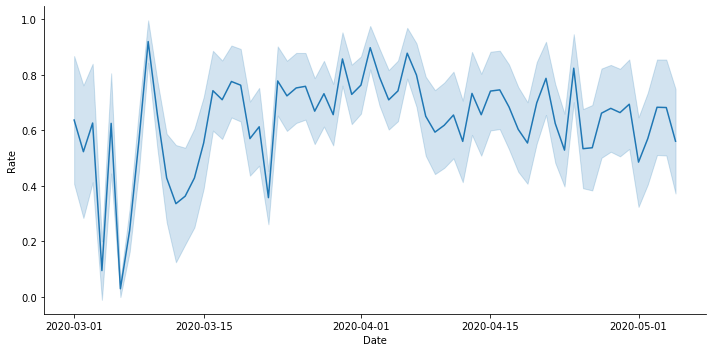

In [33]:
beta = extract_var(var_name='b', data=infer, start=start)
q = extract_var(var_name='q', data=infer, start=start)
C = extract_var(var_name='C', data=infer, start=start)
C = C[:-1]
R_D = pd.DataFrame(np.array([(beta[i].values / 0.04) * (1 - C[i]/P) for i in range(len(beta))]).T,
                 index=beta.index)

draw({'R':R_D}, line=1, name='R_Denmark', value_name='R')
draw({'Detection rate':q}, name='q_Denmark', value_name='Rate')

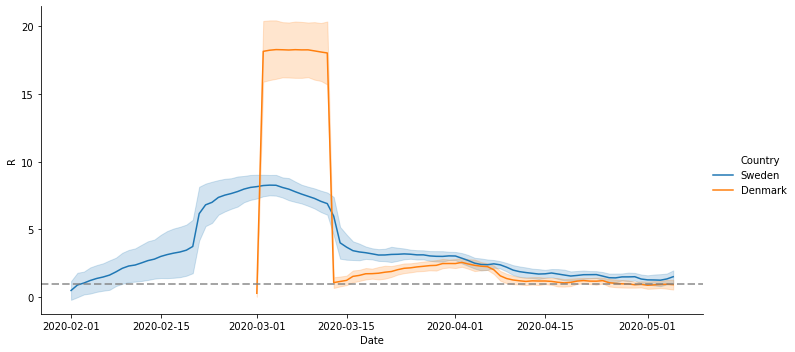

In [34]:
draw({'Sweden':R_S, 'Denmark':R_D,}, line=1, name='R_Nordic', value_name='R', label_name='Country')